## Summary -  Empty job analysis

A single month of data can produce dataframes which occupy 20G in memory. This is a little unwieldly so input for this notebook has been filtered on a single day (this case May 15th) in order to explore the data. The executive summary is in the following table where statistics are listed for jobs which Complete cleanly and jobs which are Removed with a submission problem. The 'empty pilot problem' is mostly concerned with Completed jobs where the pilot tries to get a payload from Panda but receives no work.

| HTCondor status | empty count | hit count | % count | empty wallclock days | hit wallclock days | % wallclock |
| :---            |     :---:   | :---:     | :---:   | :---:                | :---:              | :---:       |
| Completed (4)   |    323834   | 165558    | 44%     | 6119                 | 63236              | 9%          |
| Removed   (3)   |    616742   | 2430      | 99%     | 11532                | 4113               | 73%         |

### Notes
1. HTCondor in this context is referring to the pilot factory instance.
2. The job duration in seconds is measured by HTCondor using (EnteredCurrentStatus-QDate) and includes middleware lag
2. Removed jobs are where htcondor records a fault with submission usually due to a bad CE or when jobs hit the periodic_remove conditions such as staying in Idle state for too long.
3. The walltime from Removed jobs is not wasted compute resource but does add to the load on factories and CEs.
4. The high 99% fraction of Removed jobs is most likely due to broken CEs acting as blackholes. These bad CEs are not currently being handled by ADC shifters and this should be reviewed, even though it has no effect on ADC production.
5. Completed jobs are mostly likely seen by the batch systems and are expected to agree with observations at site. Comparison at specific sites should be made to confirm this.
6. Completed jobs have high 'empty' count (44%) and also high wallclock usage (9%). Further analysis is needed because this was understood to be 10% and 0.5% respectively.


### Details
Below are the analysis details with a few initial plots to sanity-check the input data. Total and mean wallclock times are listed and look sensible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import *
from pandas.io.parsers import read_csv

pd.set_option('max_colwidth',120)

#to share the notebook
%matplotlib inline

In [2]:
# these files are produced by a separate notebook 'emptiness-may-import'
panda = pd.read_pickle('panda-may141516.pickle')
history = pd.read_pickle('history-may15.pickle')

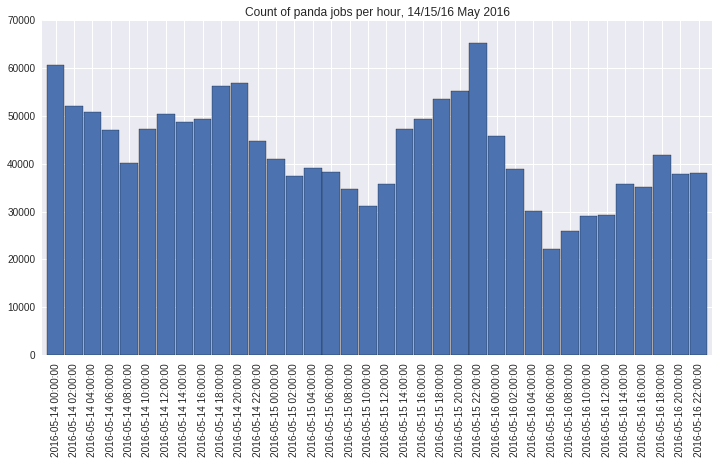

In [3]:
# extended timeperiod in order to get records near midnight (this picked up an extra 1k jobs)
panda.gtag.groupby(Grouper(freq='2h')).count().plot.bar(title='Count of panda jobs per hour, 14/15/16 May 2016', width=0.95, figsize=(12,6))

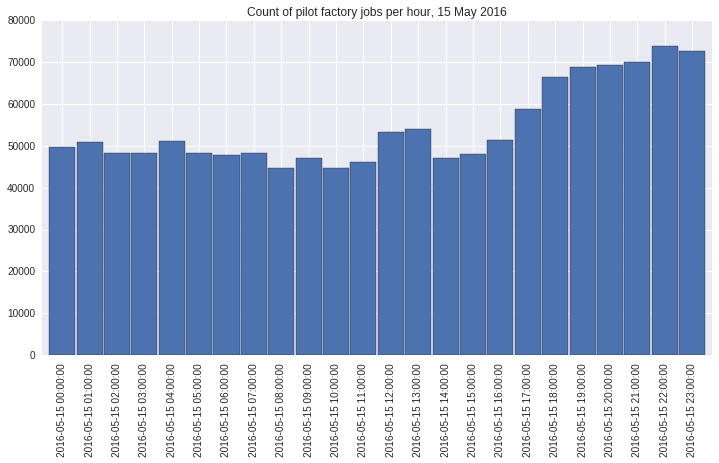

In [4]:
history.gtag.groupby(Grouper(freq='1h')).count().plot.bar(title='Count of pilot factory jobs per hour, 15 May 2016', width=0.95, figsize=(12,6))

In [5]:
m = pd.merge(history, panda, on='gtag', how='outer', sort=False, indicator=True)

In [6]:
# 'left_only' are empty pilots
# 'right_only' are in panda jobsarchive but not in htcondor history
#              these would be outside time period for example
# 'both' are jobs with payload using cern factories
m.gtag.groupby(m._merge).count()

_merge
left_only      940576
right_only    1127164
both           415382
dtype: int64

In [7]:
# duration stats on all empty jobs
m[m._merge=='left_only'].duration.describe()

count    940576.000000
mean       1621.448702
std       12085.344331
min           1.000000
25%          60.000000
50%         110.000000
75%         216.000000
max      650280.000000
Name: duration, dtype: float64

In [8]:
hit = m[m._merge=='both']
hit.set_index(DatetimeIndex(to_datetime(hit.timestamp, unit='s')), inplace=True)

In [9]:
# mean walltime per real job in hours
hit.duration.mean() / 3600

3.891280760173099

In [10]:
# total walltime for all real jobs in days
hit.duration.sum() / 3600 / 24

67348.66603009259

In [11]:
empty = m[m._merge=='left_only']
empty.set_index(DatetimeIndex(to_datetime(empty.timestamp, unit='s')), inplace=True)

In [12]:
# mean walltime per empty pilot in minutes
empty.duration.mean() / 60

27.024145027444174

In [13]:
# total walltime for empty pilots in days
empty.duration.sum() / 3600 / 24

17651.57099537037

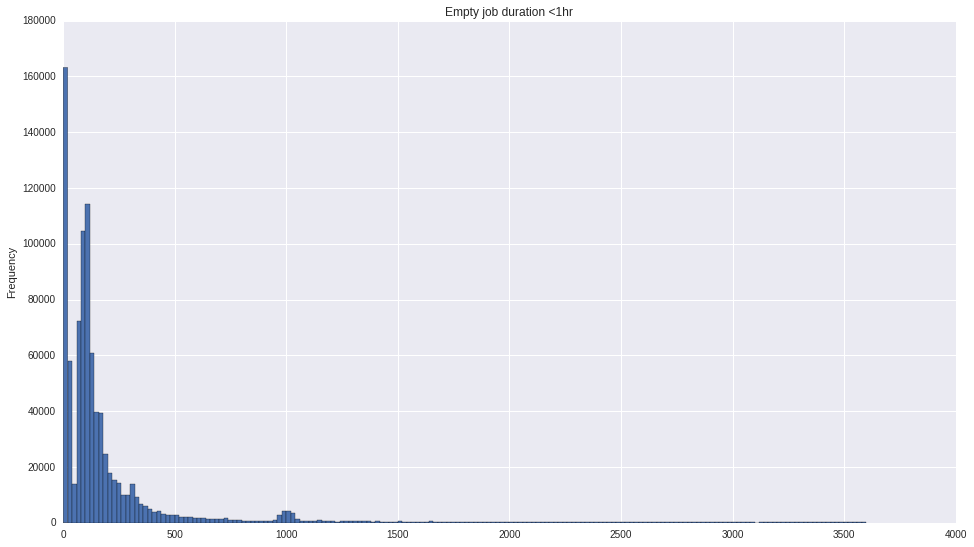

In [14]:
empty[(empty.duration < 3600)].duration.plot.hist(title="Empty job duration <1hr",bins=180,figsize=(16,9))

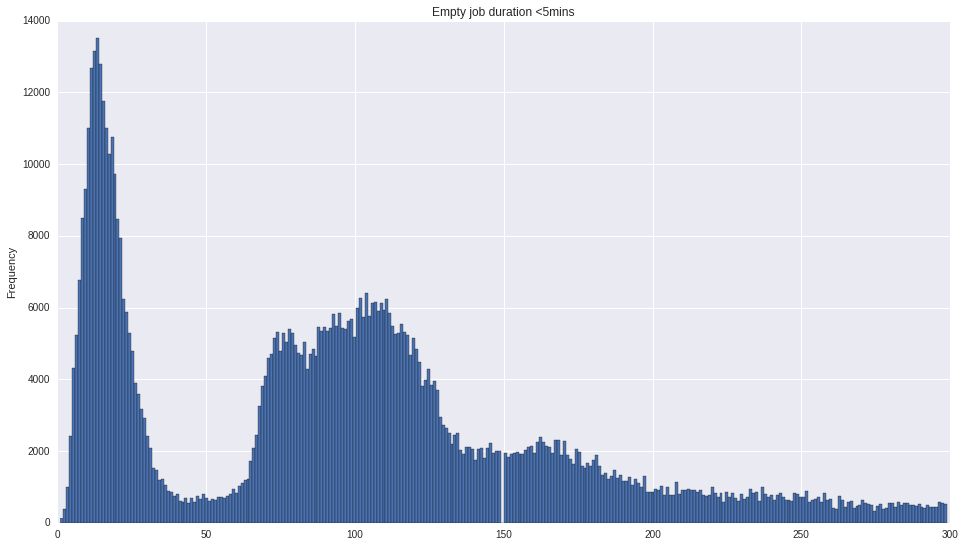

In [15]:
# check distribution of empty job duration
empty[(empty.duration < 300)].duration.plot.hist(title="Empty job duration <5mins",bins=300,figsize=(16,9))

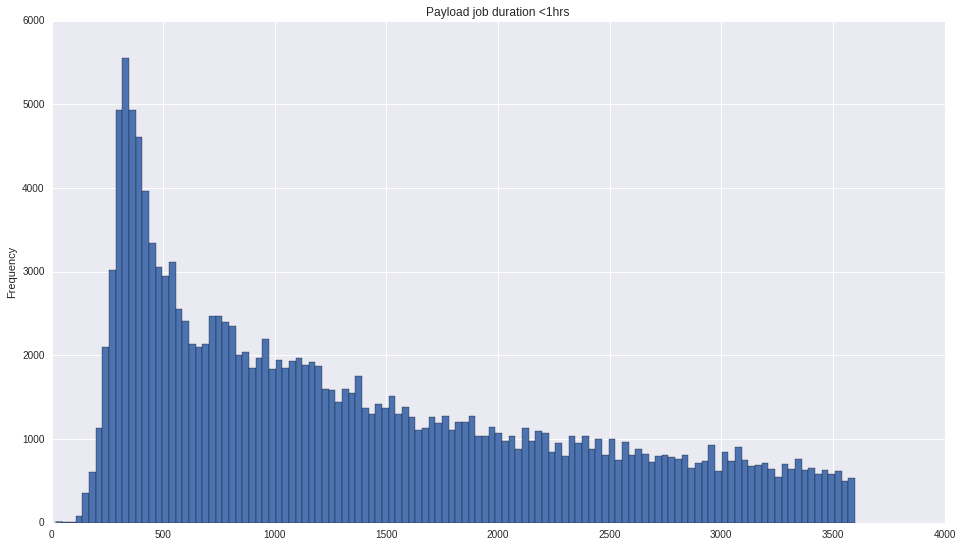

In [16]:
hit[hit.duration < 3600].duration.plot.hist(title="Payload job duration <1hrs",bins=120,figsize=(16,9))

In [17]:
empty4 = empty[empty.jobstatus == 4]
empty3 = empty[empty.jobstatus == 3]
hit4 = hit[hit.jobstatus == 4]
hit3 = hit[hit.jobstatus == 3]

In [18]:
empty3.duration.describe()

count    616742.000000
mean       1615.571341
std       14291.352255
min           1.000000
25%          19.000000
50%          87.000000
75%         120.000000
max      650280.000000
Name: duration, dtype: float64

In [19]:
hit4.duration.describe()

count    408646.000000
mean      13369.924695
std       21626.623804
min         117.000000
25%        1485.000000
50%        6093.000000
75%       16253.000000
max      402925.000000
Name: duration, dtype: float64

In [20]:
hit3.duration.describe()

count      6736.000000
mean      52755.121437
std       74608.330735
min          18.000000
25%        1340.000000
50%       10811.500000
75%       82589.500000
max      392401.000000
Name: duration, dtype: float64

In [21]:
# Good jobs with payload total walltime in days (on 15 May)
hit4.duration.sum() / 3600 / 24

63235.72045138889

In [22]:
# Good jobs mean wallclock in hours (on May15)
hit4.duration.mean() / 3600

3.713867970892492

In [23]:
# Failed jobs with payload total walltime in days (on 15 May)
hit3.duration.sum() / 3600 / 24

4112.945578703703

In [24]:
# Empty jobs total walltime in days (on 15 May)
empty4.duration.sum() / 3600 / 24

6119.271226851852

In [25]:
# Empty jobs mean wallclock in minutes (on May15)
empty4.duration.mean() / 60

27.21070229397366

In [26]:
# Empty hapless jobs total walltime in days (on 15 May)
empty3.duration.sum() / 3600 / 24

11532.299768518518

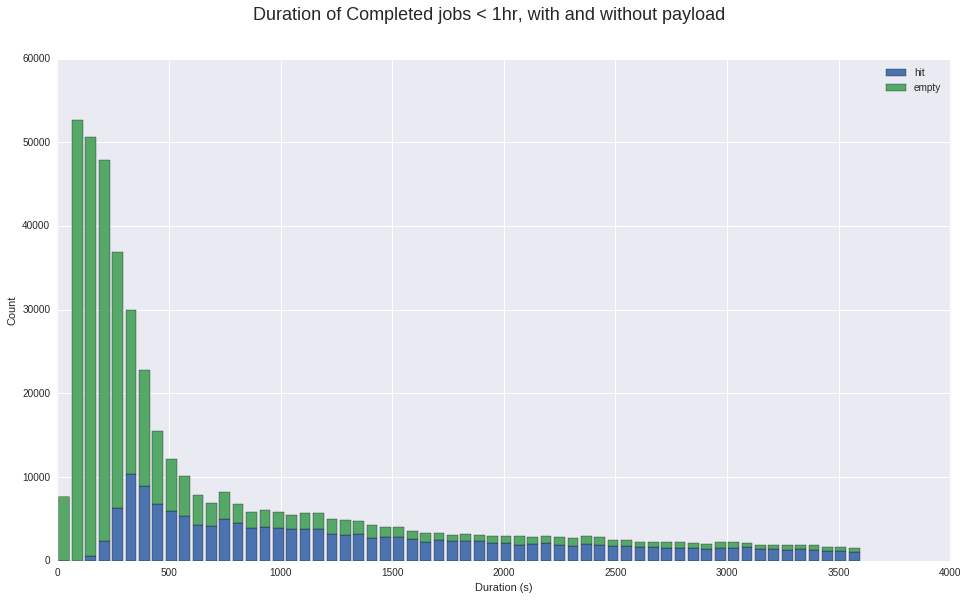

In [27]:
fig = plt.figure(figsize=(16,9))

empty4 = empty[empty.jobstatus == 4]
empty3 = empty[empty.jobstatus == 3]
hit4 = hit[hit.jobstatus == 4]
hit3 = hit[hit.jobstatus == 3]
plt.hist([hit4.duration, empty4.duration], bins=60, stacked=True, label=['hit','empty'], range=(0,3600))
fig.suptitle('Duration of Completed jobs < 1hr, with and without payload', fontsize=18)
plt.legend()
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.show()


NIKHEF-ELPROD-all-prod-CEs
Sum of walltime for empty jobs:  681.1 hr
Sum of walltime for empty jobs: 5719.6 hr
Fraction in number for empty jobs:  77%
Fraction in walltime for empty jobs: 10.6%

INFN-T1-all-prod-CEs
Sum of walltime for empty jobs: 3965.3 hr
Sum of walltime for empty jobs: 47898.5 hr
Fraction in number for empty jobs:  68%
Fraction in walltime for empty jobs: 7.6%

IN2P3-CC-all-ce-sge-long
Sum of walltime for empty jobs:   30.7 hr
Sum of walltime for empty jobs: 18025.3 hr
Fraction in number for empty jobs:   4%
Fraction in walltime for empty jobs: 0.2%

FZK-LCG2-all-prod-CEs
Sum of walltime for empty jobs:  248.9 hr
Sum of walltime for empty jobs: 7625.3 hr
Fraction in number for empty jobs:  26%
Fraction in walltime for empty jobs: 3.2%



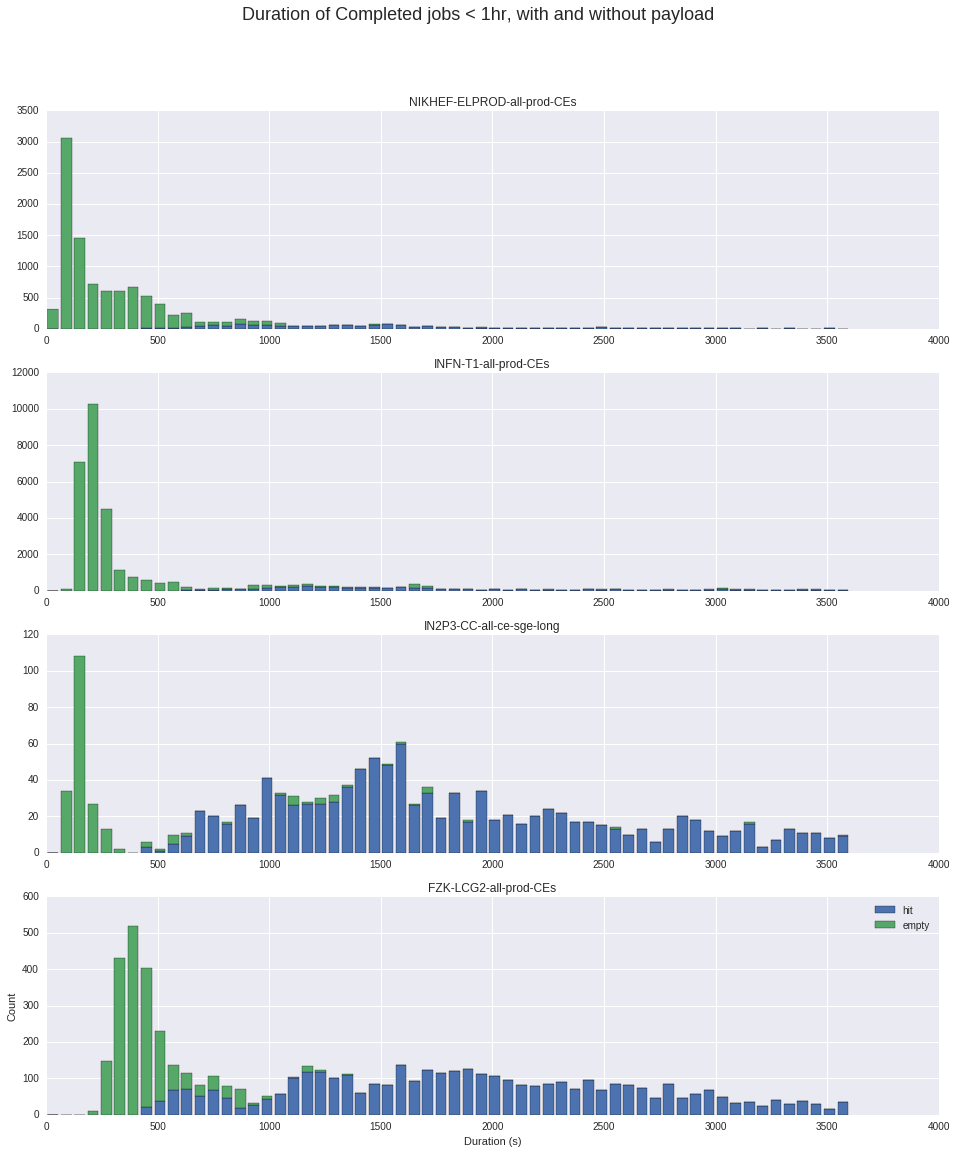

In [28]:
#fig = plt.figure(figsize=(16,9))
fig, axs = plt.subplots(nrows=4, figsize=(16,18))

pqs = ['NIKHEF-ELPROD-all-prod-CEs','INFN-T1-all-prod-CEs','IN2P3-CC-all-ce-sge-long','FZK-LCG2-all-prod-CEs']
for pq,ax in zip(pqs, axs):   
    empty4 = empty[(empty.jobstatus == 4) & (empty.gtag.str.contains(pq))]
    empty3 = empty[(empty.jobstatus == 3) & (empty.gtag.str.contains(pq))]
    hit4 = hit[(hit.jobstatus == 4) & (hit.gtag.str.contains(pq))]
    hit3 = hit[(hit.jobstatus == 3) & (hit.gtag.str.contains(pq))]
    ax.hist([hit4.duration, empty4.duration], stacked=True, bins=60, label=['hit','empty'], range=(0,3600))
    ax.set_title(pq)

    # sum of walltime used for empty and hit jobs
    esum = empty4.duration.sum() / 3600
    hsum = hit4.duration.sum() / 3600
    print(pq)
    
    print('Sum of walltime for empty jobs: %6.1f hr' % esum)
    print('Sum of walltime for empty jobs: %6.1f hr' % hsum)

    nfrac = 100 * empty4.gtag.count() / (empty4.gtag.count() + hit4.gtag.count())
    print('Fraction in number for empty jobs: %3.0f%%' % nfrac)

    ntime = 100*esum/(esum+hsum)
    print('Fraction in walltime for empty jobs: %3.1f%%' % ntime)
#    print('Empty walltime sum (days): %6.1f' % days)
    print()

fig.suptitle("Duration of Completed jobs < 1hr, with and without payload", fontsize=18)
plt.legend()
plt.xlabel('Duration (s)')
plt.ylabel('Count')
#plt.xkcd()
plt.show()
